In [1]:
!pip install d2l
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

     |████████████████████████████████| 92kB 5.3MB/s 


In [2]:
#11.11.1. 构造模型
#下面，我们使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征，并将该网络实例记为pretrained_net。 
#该模型的最后几层包括全局平均池化层和全连接层，然而全卷积网络中不需要它们。
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
#接下来，我们创建一个全卷积网络实例net。 它复制了Resnet-18中大部分的预训练层，但除去最终的全局平均池化层和最接近输出的全连接层。
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [4]:
#给定高度和宽度分别为320和480的输入，net的前向计算将输入的高和宽减小至原来的1/32，即10和15。
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 512, 10, 15])

In [5]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module(
    'transpose_conv',
    nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16,
                       stride=32))

In [6]:
#11.11.2. 初始化转置卷积层
#双线性插值的上采样可以通过转置卷积层实现，内核由以下bilinear_kernel函数构造。 
#限于篇幅，我们只给出bilinear_kernel函数的实现，不讨论算法的原理。
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros(
        (in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [7]:
#让我们用双线性插值的上采样实验它由转置卷积层实现。 我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [8]:
#读取图像X，将上采样的结果记作Y。为了打印图像，我们需要调整通道维的位置。
img = torchvision.transforms.ToTensor()(d2l.Image.open('./catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([284, 361, 3])
output image shape: torch.Size([568, 722, 3])


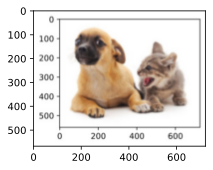

In [9]:
#可以看到，转置卷积层将图像的高和宽分别放大了2倍。 除了坐标刻度不同，双线性插值放大的图像和在 11.3节中打印出的原图看上去没什么两样。
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In [10]:
#在全卷积网络中，我们用双线性插值的上采样初始化转置卷积层。对于 1×1 卷积层，我们使用Xavier初始化参数。
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [11]:
#11.11.3. 读取数据集
#我们用 11.9节 中介绍的语义分割读取数据集。 指定随机裁剪的输出图像的形状为 320×480 ：高和宽都可以被 32 整除。
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


read 1078 examples


loss 0.414, train acc 0.870, test acc 0.847
81.6 examples/sec on [device(type='cuda', index=0)]


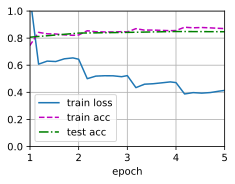

In [12]:
#11.11.4. 训练
#现在我们可以训练全卷积网络了。 这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，
#因为我们使用转置卷积层的通道来预测像素的类别，所以在损失计算中通道维是指定的。 此外，模型基于每个像素的预测类别是否正确来计算准确率。
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [13]:
#11.11.5. 预测
#在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [14]:
#为了可视化预测的类别给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

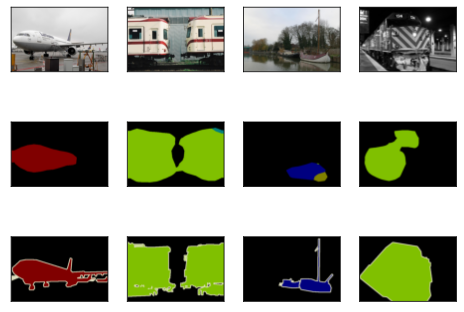

In [15]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i], *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);